# Inventory Analytics using SQLite3 and Python

In [35]:
# Inventory Analytics in Jupyter Notebook

# Step 1: Import required libraries
import pandas as pd
import sqlite3

# Step 2: Load the dataset
df = pd.read_csv("inventory_forecasting.csv")  # Change path if needed
df.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0096,Toys,West,158,134,142,152.36,40.88,5,Sunny,1,42.39,Winter
1,2022-01-01,S001,P0016,Clothing,East,189,127,125,150.47,90.78,0,Rainy,0,84.16,Winter
2,2022-01-01,S001,P0031,Electronics,West,75,48,39,68.62,13.99,20,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0159,Electronics,West,161,74,71,75.46,84.92,10,Snowy,0,83.03,Winter
4,2022-01-01,S001,P0129,Furniture,South,135,66,69,67.18,19.66,0,Cloudy,0,20.55,Winter


In [36]:
conn = sqlite3.connect("inventory_dashboard.db")  # Save to file
df.to_sql("inventory", conn, index=False, if_exists="replace")

109500

In [37]:
# Step 3: Create in-memory SQLite database
conn = sqlite3.connect(":memory:")
df.to_sql("inventory", conn, index=False, if_exists="replace")


109500

# 4.1 Stock Level Calculation

,Product ID,Avg_Stock
0,P0016,155.221096
1,P0057,155.087945
2,P0125,154.882192
3,P0187,154.869315
4,P0061,154.775342
5,P0066,154.667123
6,P0046,154.506301
7,P0069,154.473151
8,P0133,154.356986
9,P0178,153.986575


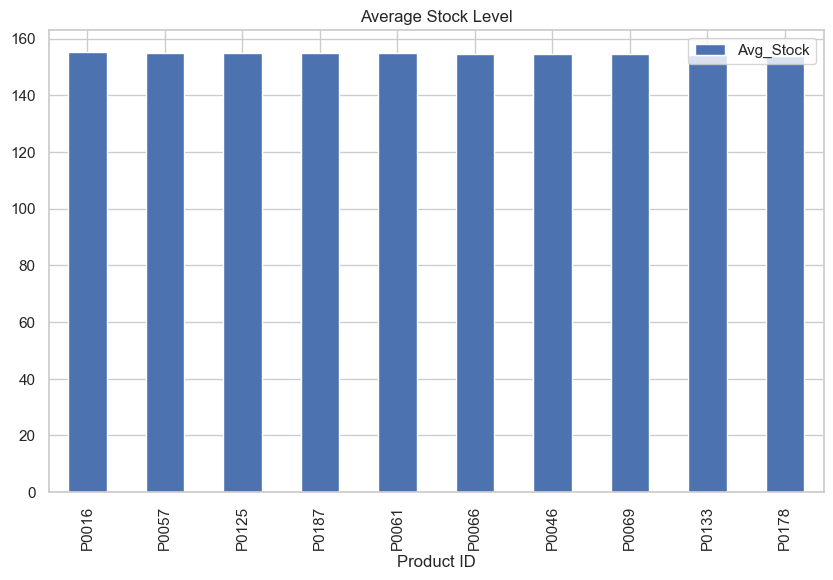

In [38]:
# 4.1 Stock Level Calculation
query = """
SELECT "Product ID", AVG("Inventory Level") AS Avg_Stock
FROM inventory
GROUP BY "Product ID"
ORDER BY Avg_Stock DESC
LIMIT 10;
"""
avg_stock = pd.read_sql(query, conn)
avg_stock.plot(x="Product ID", y="Avg_Stock", kind="bar", title="Average Stock Level")
avg_stock


# 4.2 Low Inventory Detection

In [39]:
# 4.2 Low Inventory Detection
query = """
SELECT DISTINCT "Product ID", "Store ID", "Inventory Level"
FROM inventory
WHERE "Inventory Level" < 50
ORDER BY "Inventory Level" ASC
LIMIT 10;
"""
low_stock = pd.read_sql(query, conn)
low_stock


,Product ID,Store ID,Inventory Level
0,P0175,S004,20
1,P0149,S005,20
2,P0153,S002,20
3,P0057,S002,20
4,P0046,S005,20
5,P0153,S001,20
6,P0171,S004,20
7,P0125,S004,21
8,P0187,S001,21
9,P0067,S001,21


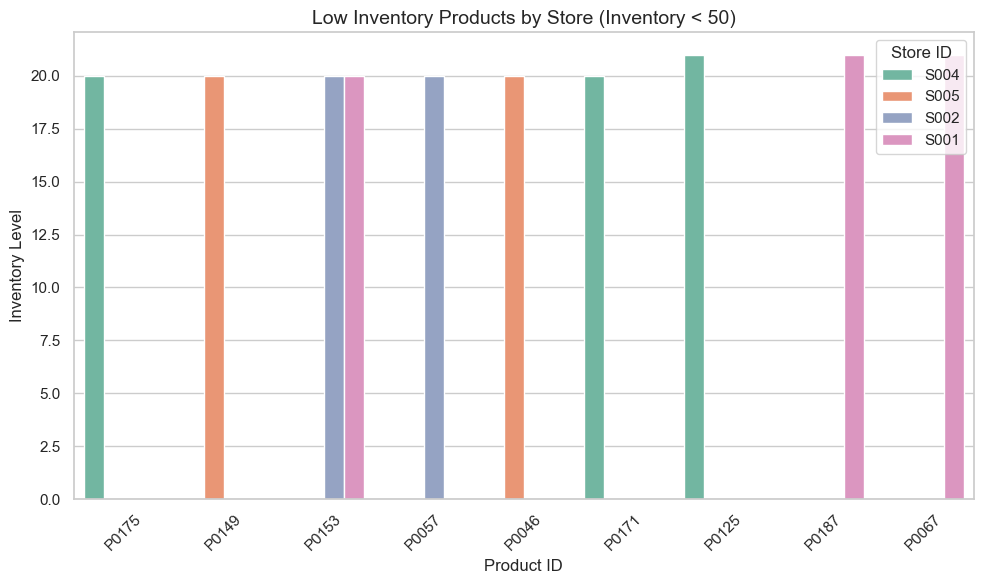

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=low_stock, x="Product ID", y="Inventory Level", hue="Store ID", palette="Set2")
plt.title("Low Inventory Products by Store (Inventory < 50)", fontsize=14)
plt.xlabel("Product ID")
plt.ylabel("Inventory Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4.3 Reorder Point Estimation

In [41]:
# 4.3 Reorder Point Estimation
query = """
SELECT "Product ID",
       ROUND(AVG("Demand Forecast") * 3, 2) AS Reorder_Point
FROM inventory
GROUP BY "Product ID"
ORDER BY Reorder_Point DESC
LIMIT 10;
"""
reorder_point = pd.read_sql(query, conn)
reorder_point


,Product ID,Reorder_Point
0,P0046,355.58
1,P0057,354.73
2,P0187,354.55
3,P0133,354.43
4,P0125,353.12
5,P0016,353.04
6,P0066,352.76
7,P0061,352.02
8,P0178,351.84
9,P0069,351.16


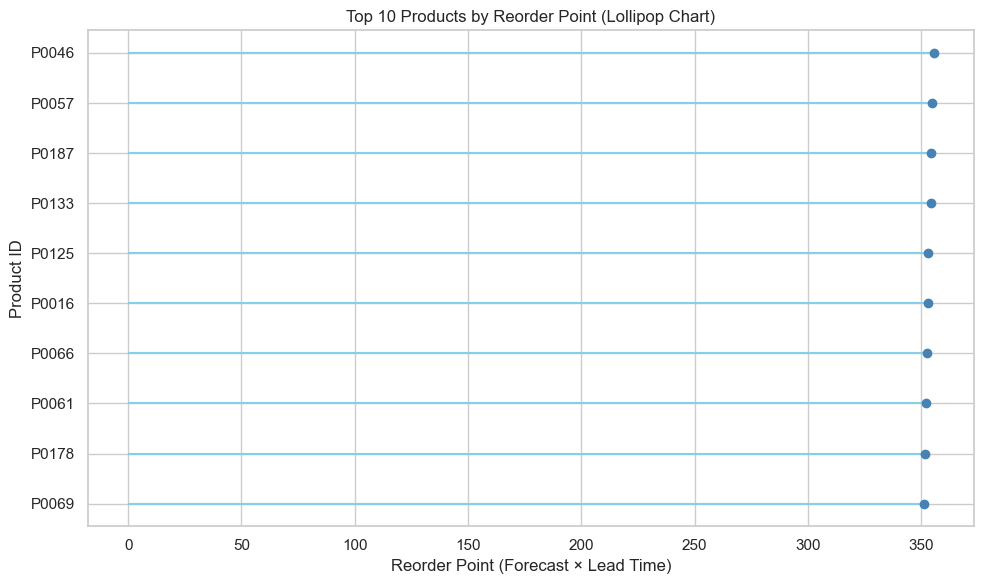

In [42]:
import matplotlib.pyplot as plt

# Sort for visual consistency
reorder_point_sorted = reorder_point.sort_values("Reorder_Point", ascending=True)

plt.figure(figsize=(10, 6))
plt.hlines(y=reorder_point_sorted["Product ID"], xmin=0, xmax=reorder_point_sorted["Reorder_Point"], color='skyblue')
plt.plot(reorder_point_sorted["Reorder_Point"], reorder_point_sorted["Product ID"], "o", color='steelblue')
plt.title("Top 10 Products by Reorder Point (Lollipop Chart)")
plt.xlabel("Reorder Point (Forecast × Lead Time)")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()


C:\Users\91876\AppData\Local\Temp\ipykernel_19904\3747859322.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reorder_point, x="Product ID", y="Reorder_Point", palette="coolwarm")


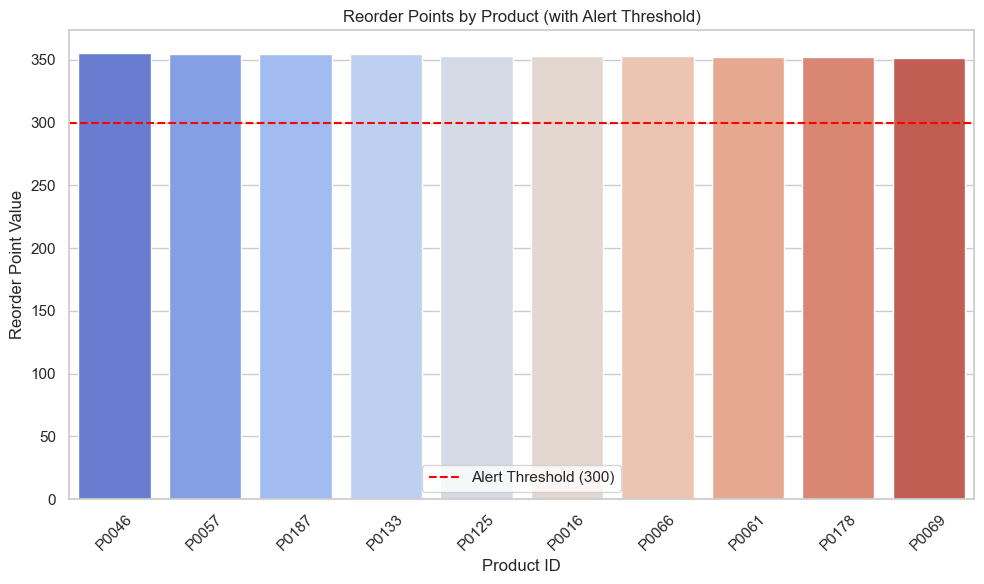

In [43]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=reorder_point, x="Product ID", y="Reorder_Point", palette="coolwarm")
plt.axhline(300, color='red', linestyle='--', label="Alert Threshold (300)")
plt.title("Reorder Points by Product (with Alert Threshold)")
plt.ylabel("Reorder Point Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


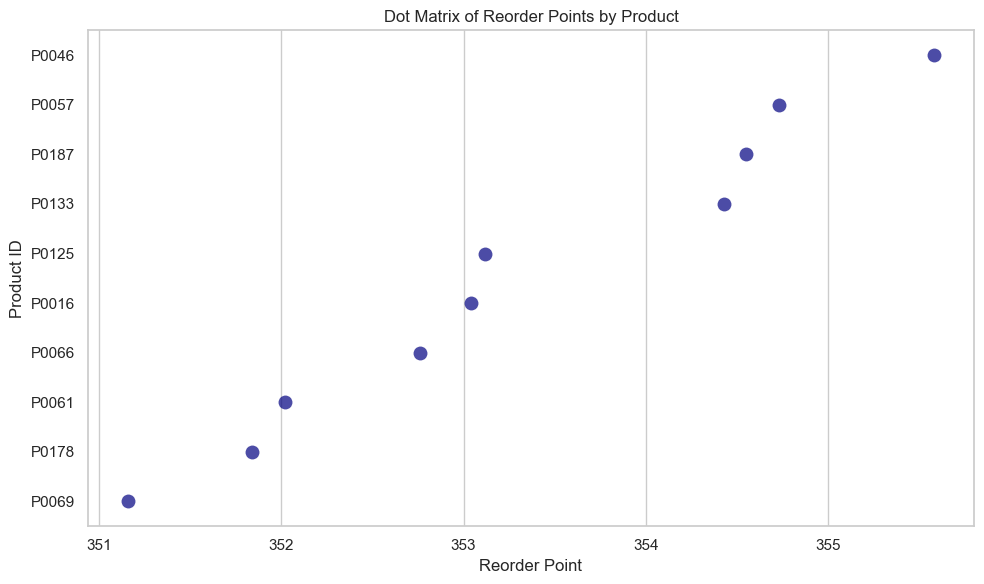

In [44]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=reorder_point, y="Product ID", x="Reorder_Point", size=10, color='navy', alpha=0.7)
plt.title("Dot Matrix of Reorder Points by Product")
plt.xlabel("Reorder Point")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()


# 4.4 Inventory Turnover Ratio

In [45]:
# 4.4 Inventory Turnover Ratio
query = """
SELECT "Product ID",
       ROUND(SUM("Units Sold") * 1.0 / AVG("Inventory Level"), 2) AS Inventory_Turnover
FROM inventory
GROUP BY "Product ID"
ORDER BY Inventory_Turnover DESC
LIMIT 10;
"""
turnover = pd.read_sql(query, conn)
turnover


,Product ID,Inventory_Turnover
0,P0046,2503.49
1,P0133,2499.68
2,P0057,2496.71
3,P0178,2496.58
4,P0187,2489.73
5,P0066,2487.69
6,P0125,2486.64
7,P0061,2485.33
8,P0069,2479.19
9,P0016,2477.17


C:\Users\91876\AppData\Local\Temp\ipykernel_19904\1247062573.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=turnover, y="Product ID", x="Inventory_Turnover", palette="crest")


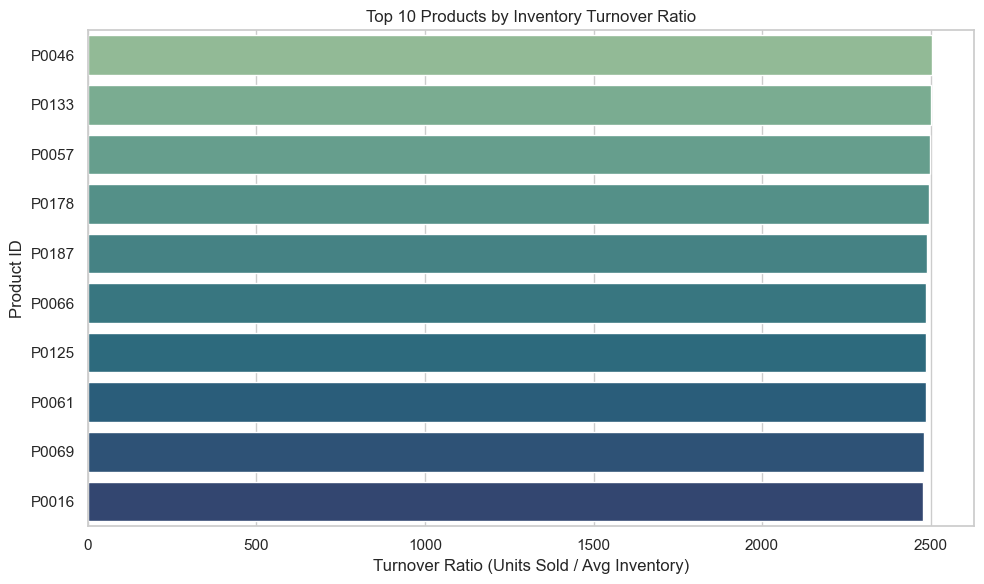

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=turnover, y="Product ID", x="Inventory_Turnover", palette="crest")
plt.title("Top 10 Products by Inventory Turnover Ratio")
plt.xlabel("Turnover Ratio (Units Sold / Avg Inventory)")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()


C:\Users\91876\AppData\Local\Temp\ipykernel_19904\4135837103.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


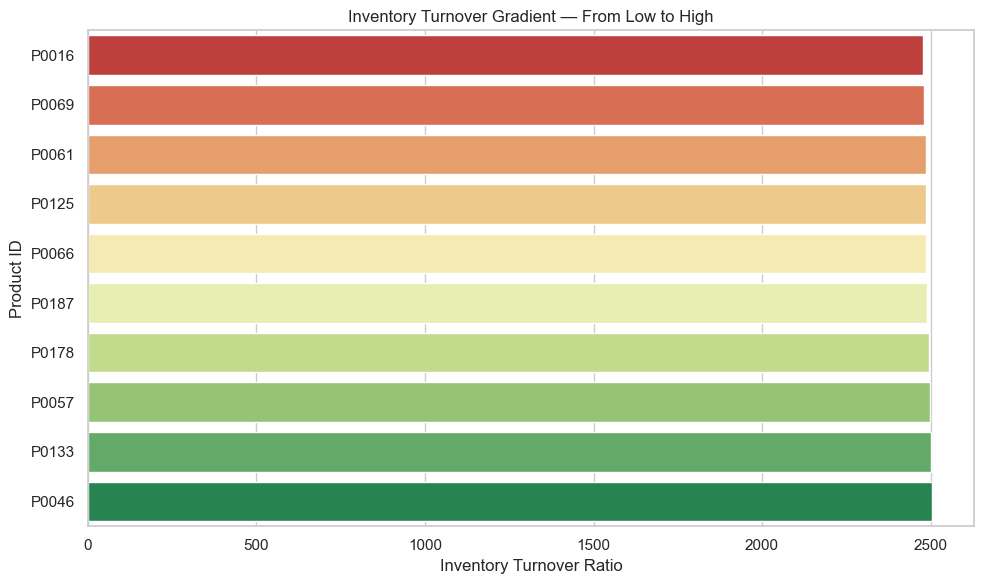

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=turnover.sort_values("Inventory_Turnover", ascending=True),
    x="Inventory_Turnover", y="Product ID", palette="RdYlGn"
)
plt.title("Inventory Turnover Gradient — From Low to High")
plt.xlabel("Inventory Turnover Ratio")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()


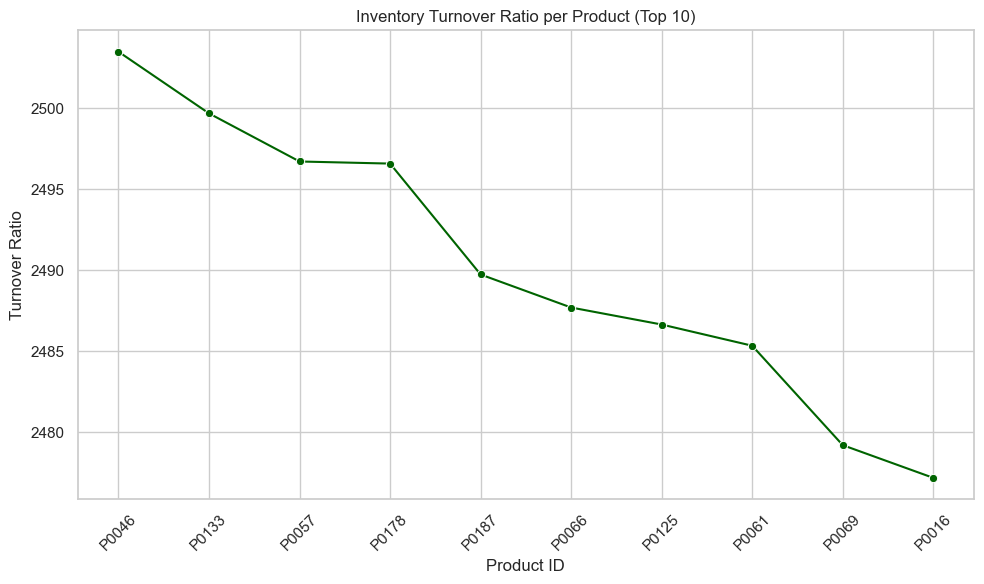

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=turnover, x="Product ID", y="Inventory_Turnover", marker='o', color='darkgreen')
plt.title("Inventory Turnover Ratio per Product (Top 10)")
plt.xlabel("Product ID")
plt.ylabel("Turnover Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 4.5 Stockout Rate Analysis

In [49]:
# 4.5 Stockout Rate Analysis
query = """
SELECT "Product ID",
       ROUND(SUM(CASE WHEN "Inventory Level" = 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*), 3) AS Stockout_Rate
FROM inventory
GROUP BY "Product ID"
ORDER BY Stockout_Rate DESC
LIMIT 10;
"""
stockout = pd.read_sql(query, conn)
stockout


,Product ID,Stockout_Rate
0,P0187,0.0
1,P0183,0.0
2,P0178,0.0
3,P0175,0.0
4,P0171,0.0
5,P0166,0.0
6,P0159,0.0
7,P0153,0.0
8,P0149,0.0
9,P0133,0.0


C:\Users\91876\AppData\Local\Temp\ipykernel_19904\3114276260.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stockout, x="Product ID", y="Stockout_Rate", palette="Reds")


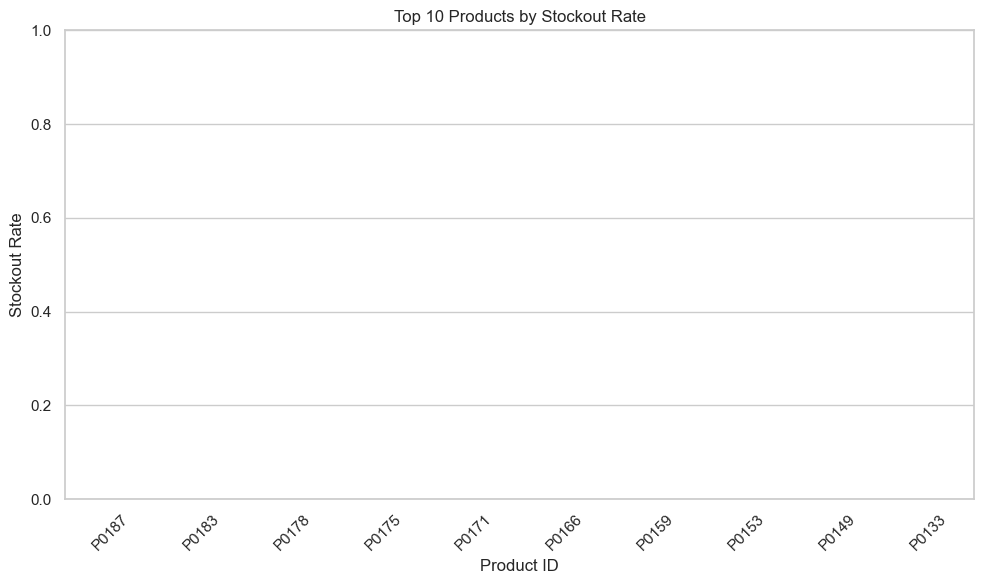

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=stockout, x="Product ID", y="Stockout_Rate", palette="Reds")
plt.title("Top 10 Products by Stockout Rate")
plt.ylabel("Stockout Rate")
plt.xlabel("Product ID")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Rate between 0 and 1
plt.tight_layout()
plt.show()


C:\Users\91876\AppData\Local\Temp\ipykernel_19904\2855990499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


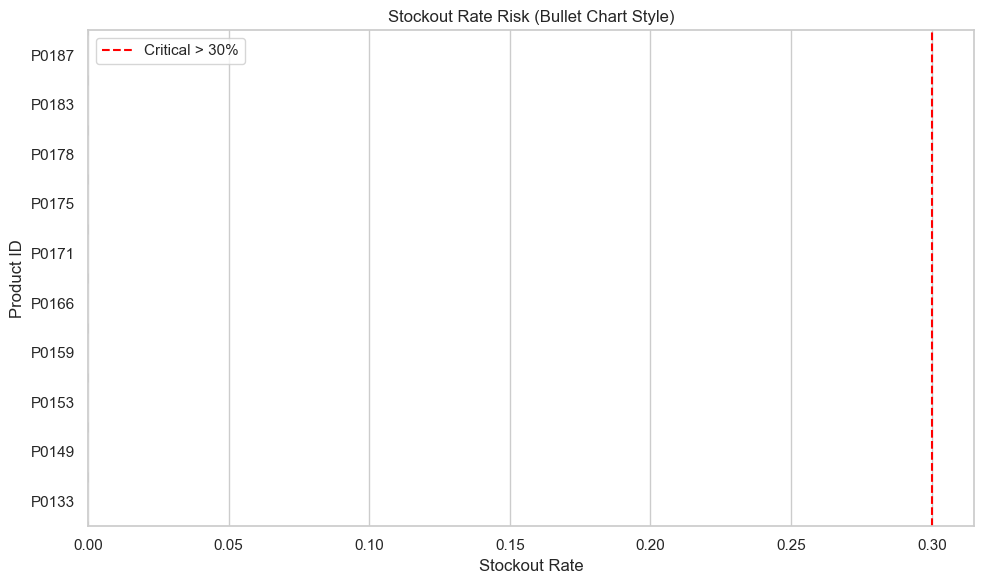

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stockout.sort_values("Stockout_Rate", ascending=True),
    y="Product ID", x="Stockout_Rate", palette="coolwarm"
)
plt.axvline(0.3, color='red', linestyle='--', label="Critical > 30%")
plt.title("Stockout Rate Risk (Bullet Chart Style)")
plt.xlabel("Stockout Rate")
plt.legend()
plt.tight_layout()
plt.show()


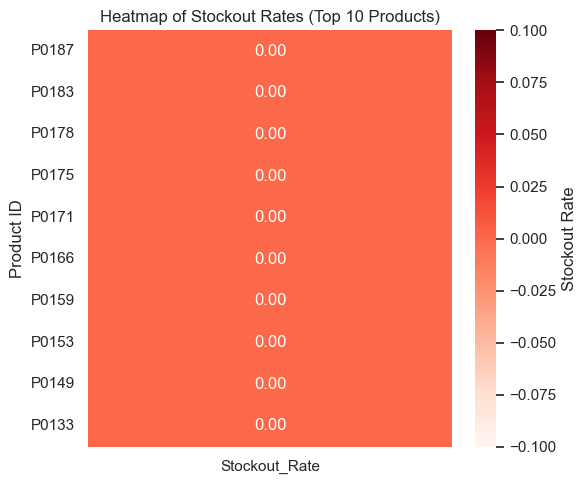

In [52]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    stockout.set_index("Product ID"),
    annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Stockout Rate'}
)
plt.title("Heatmap of Stockout Rates (Top 10 Products)")
plt.tight_layout()
plt.show()


# 4.6 Fast vs Slow-Moving Products (Pareto Principle)

In [53]:
# 4.6 Fast vs Slow-Moving Products (Pareto Principle)
# Get total units sold per product
total_sales = df.groupby("Product ID")["Units Sold"].sum().sort_values(ascending=False)

# Apply Pareto principle: 80% sales from top 20% products
cumulative = total_sales.cumsum()
threshold = total_sales.sum() * 0.8
fast_movers = cumulative[cumulative <= threshold].index
slow_movers = cumulative[cumulative > threshold].index

print(f"Total Products: {len(total_sales)}")
print(f"Fast Movers (Top 20% of sales): {len(fast_movers)}")
print(f"Slow Movers: {len(slow_movers)}")


Total Products: 30
Fast Movers (Top 20% of sales): 23
Slow Movers: 7


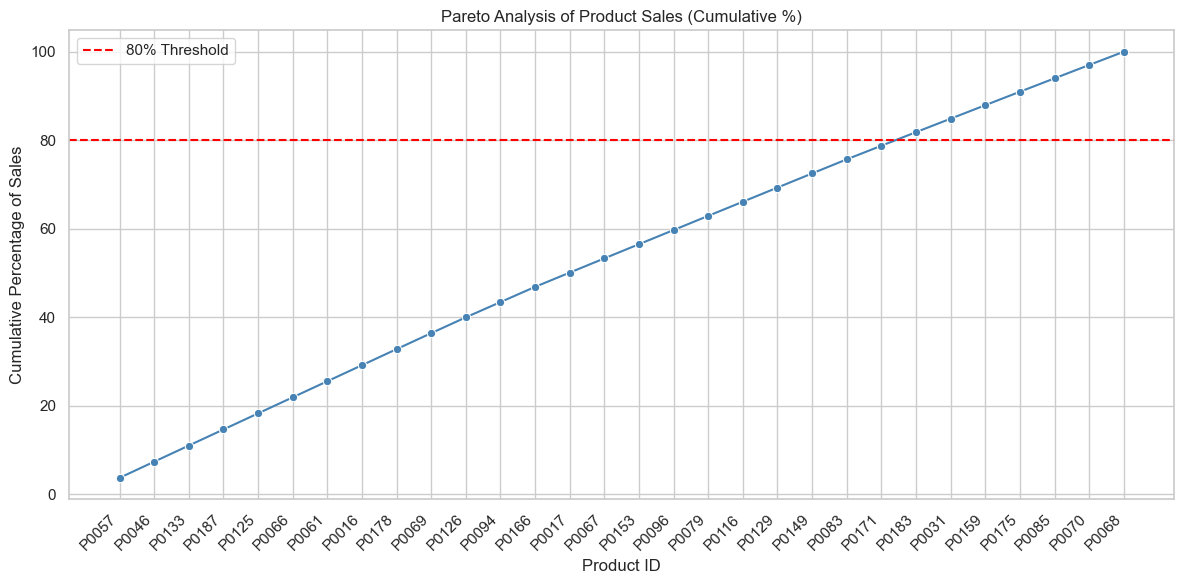

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index and compute cumulative %
pareto_df = total_sales.reset_index()
pareto_df.columns = ["Product ID", "Total Units Sold"]
pareto_df["Cumulative Units"] = pareto_df["Total Units Sold"].cumsum()
pareto_df["Cumulative %"] = pareto_df["Cumulative Units"] / pareto_df["Total Units Sold"].sum() * 100

# Line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=pareto_df, x="Product ID", y="Cumulative %", marker='o', color='steelblue')
plt.axhline(80, color='red', linestyle='--', label="80% Threshold")
plt.title("Pareto Analysis of Product Sales (Cumulative %)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cumulative Percentage of Sales")
plt.legend()
plt.tight_layout()
plt.show()


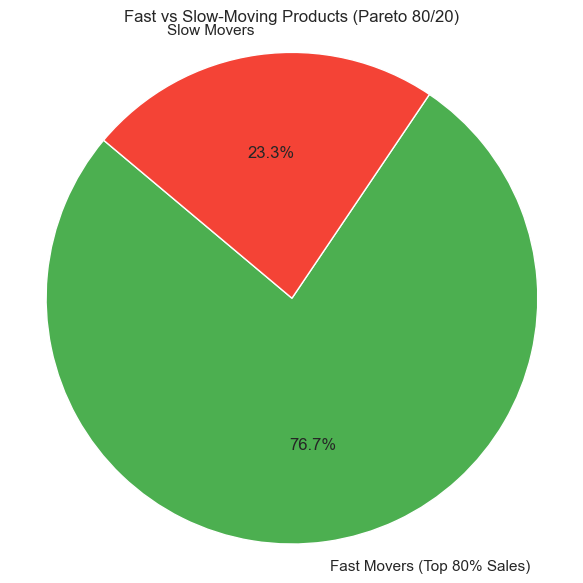

In [55]:
labels = ["Fast Movers (Top 80% Sales)", "Slow Movers"]
sizes = [len(fast_movers), len(slow_movers)]
colors = ["#4CAF50", "#F44336"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
plt.title("Fast vs Slow-Moving Products (Pareto 80/20)")
plt.axis("equal")
plt.tight_layout()
plt.show()
